[2025-05-12] 예측가: 12571.77원, 실제가: 13439.00원
[2025-05-13] 예측가: 12825.83원, 실제가: 9980.00원
[2025-05-14] 예측가: 11357.80원, 실제가: 9361.00원
[2025-05-15] 예측가: 8191.44원, 실제가: 10318.00원
[2025-05-16] 예측가: 8691.84원, 실제가: 5514.00원
[2025-05-17] 예측가: 9354.46원, 실제가: 6412.00원
[2025-05-19] 예측가: 5329.72원, 실제가: 6955.00원
[2025-05-20] 예측가: 6483.28원, 실제가: 6449.00원


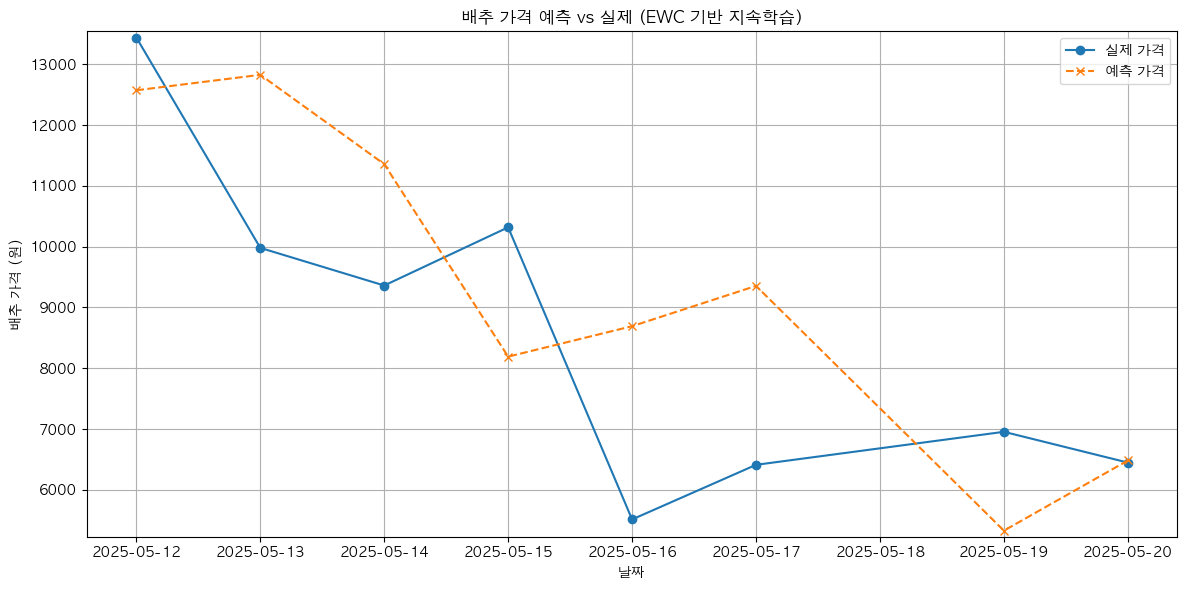

In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# macOS 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 설정
SEED = 42
WINDOW = 7
EPOCHS = 30
LR = 1e-3
LAMBDA_EWC = 100

torch.manual_seed(SEED)
np.random.seed(SEED)

# 데이터 불러오기
df = pd.read_csv("cabbage_separated.csv")
df = df[df['rate'] == 'Special'].copy()
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df[df['month'].isin([4, 5, 6])].sort_values('date').reset_index(drop=True)

# 피처 엔지니어링
df['prev_price'] = df['avg_price'].shift(1)
df['price_diff'] = df['avg_price'] - df['prev_price']
df['rolling_mean'] = df['avg_price'].rolling(window=3).mean()
df['rolling_std'] = df['avg_price'].rolling(window=3).std()
df = df.dropna()
df['log_price'] = np.log1p(df['avg_price'])

# 정규화
feature_cols = ['intake', 'gap', 'price_diff', 'rolling_mean', 'rolling_std']
target_col = 'log_price'
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
df[feature_cols] = scaler_x.fit_transform(df[feature_cols])
df[[target_col]] = scaler_y.fit_transform(df[[target_col]])

# 시계열 시퀀스 생성
X_seq, y_seq, dates = [], [], []
for i in range(len(df) - WINDOW):
    window = df.iloc[i:i+WINDOW]
    target = df.iloc[i+WINDOW]
    X_seq.append(window[feature_cols].values)
    y_seq.append(target[target_col])
    dates.append(target['date'])

X_seq = torch.tensor(np.array(X_seq), dtype=torch.float32)
y_seq = torch.tensor(np.array(y_seq), dtype=torch.float32)

# 예측 시작 시점
cutoff = pd.to_datetime("2025-05-10")

# 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# EWC 정의
class EWC:
    def __init__(self, model, dataloader, criterion):
        self.model = model
        self.criterion = criterion
        self.dataloader = dataloader
        self.params = {n: p.clone().detach() for n, p in model.named_parameters() if p.requires_grad}
        self._precision_matrices = self._diag_fisher()
    def _diag_fisher(self):
        precision = {n: torch.zeros_like(p) for n, p in self.model.named_parameters() if p.requires_grad}
        self.model.eval()
        for x, y in self.dataloader:
            self.model.zero_grad()
            out = self.model(x)
            loss = self.criterion(out.squeeze(-1), y)
            loss.backward()
            for n, p in self.model.named_parameters():
                if p.requires_grad:
                    precision[n] += p.grad.data.pow(2)
        return {n: p / len(self.dataloader) for n, p in precision.items()}
    def penalty(self, model):
        return sum((self._precision_matrices[n] * (p - self.params[n]).pow(2)).sum()
                   for n, p in model.named_parameters() if p.requires_grad)

# 모델 초기화
model = LSTMModel(input_size=len(feature_cols))
optimizer = AdamW(model.parameters(), lr=LR)
criterion = nn.MSELoss()

# 초기 학습 데이터
init_idx = [i for i, d in enumerate(dates) if d <= cutoff]
X_init, y_init = X_seq[init_idx], y_seq[init_idx]
init_loader = DataLoader(TensorDataset(X_init, y_init), batch_size=16, shuffle=True)

# 초기 학습
for epoch in range(EPOCHS):
    model.train()
    for x, y in init_loader:
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred.squeeze(-1), y)
        loss.backward()
        optimizer.step()

# EWC 저장
ewc_list = [EWC(model, init_loader, criterion)]

# 결과 저장
results = []

# 지속 학습 + 예측 루프
for i in range(len(X_seq)):
    if dates[i] <= cutoff:
        continue

    # 예측
    model.eval()
    with torch.no_grad():
        pred = model(X_seq[i].unsqueeze(0)).item()
        real = y_seq[i].item()
        pred_log = scaler_y.inverse_transform([[pred]])[0][0]
        real_log = scaler_y.inverse_transform([[real]])[0][0]
        pred_rescaled = np.expm1(pred_log)
        real_rescaled = np.expm1(real_log)
        results.append((dates[i], pred_rescaled, real_rescaled))
        print(f"[{dates[i].date()}] 예측가: {pred_rescaled:.2f}원, 실제가: {real_rescaled:.2f}원")

    # 어제 데이터로 재학습
    if i > 0 and dates[i - 1] > cutoff:
        loader = DataLoader(TensorDataset(X_seq[i-1].unsqueeze(0), y_seq[i-1].unsqueeze(0)), batch_size=1)
        model.train()
        for epoch in range(EPOCHS):
            for x, y in loader:
                optimizer.zero_grad()
                out = model(x)
                loss = criterion(out.squeeze(-1), y)
                for ewc in ewc_list:
                    loss += LAMBDA_EWC * ewc.penalty(model)
                loss.backward()
                optimizer.step()
        ewc_list.append(EWC(model, loader, criterion))

# 시각화
if len(results) == 0:
    print("❗ 예측 결과가 없습니다. cutoff 날짜 이후 데이터가 충분한지 확인하세요.")
else:
    res_dates = [r[0] for r in results]
    res_preds = [r[1] for r in results]
    res_reals = [r[2] for r in results]

    plt.figure(figsize=(12, 6))
    plt.plot(res_dates, res_reals, label='실제 가격', marker='o')
    plt.plot(res_dates, res_preds, label='예측 가격', linestyle='--', marker='x')
    plt.title("배추 가격 예측 vs 실제 (EWC 기반 지속학습)")
    plt.xlabel("날짜")
    plt.ylabel("배추 가격 (원)")
    plt.ylim(min(res_preds + res_reals) - 100, max(res_preds + res_reals) + 100)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW

class CabbagePredictor:
    def __init__(self, csv_path, cutoff_date, window=7, hidden_size=64, num_layers=2, dropout=0.2, epochs=30, lr=1e-3, lambda_ewc=100):
        self.window = window
        self.cutoff = pd.to_datetime(cutoff_date)
        self.epochs = epochs
        self.lr = lr
        self.lambda_ewc = lambda_ewc
        self.feature_cols = ['intake', 'gap', 'price_diff', 'rolling_mean', 'rolling_std']
        self.target_col = 'log_price'
        self.scaler_x = MinMaxScaler()
        self.scaler_y = MinMaxScaler()
        self.X_seq, self.y_seq, self.dates = self._load_and_process_data(csv_path)
        self.model = self._build_model(len(self.feature_cols), hidden_size, num_layers, dropout)
        self.optimizer = AdamW(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        self.ewc_list = []
        self.results = []

    def _load_and_process_data(self, path):
        df = pd.read_csv(path)
        df = df[df['rate'] == 'Special'].copy()
        df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
        df = df[df['month'].isin([4, 5, 6])].sort_values('date').reset_index(drop=True)

        df['prev_price'] = df['avg_price'].shift(1)
        df['price_diff'] = df['avg_price'] - df['prev_price']
        df['rolling_mean'] = df['avg_price'].rolling(window=3).mean()
        df['rolling_std'] = df['avg_price'].rolling(window=3).std()
        df = df.dropna()
        df['log_price'] = np.log1p(df['avg_price'])

        df[self.feature_cols] = self.scaler_x.fit_transform(df[self.feature_cols])
        df[[self.target_col]] = self.scaler_y.fit_transform(df[[self.target_col]])

        X_seq, y_seq, dates = [], [], []
        for i in range(len(df) - self.window):
            window = df.iloc[i:i + self.window]
            target = df.iloc[i + self.window]
            X_seq.append(window[self.feature_cols].values)
            y_seq.append(target[self.target_col])
            dates.append(target['date'])

        return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32), dates

    def _build_model(self, input_size, hidden_size, num_layers, dropout):
        class LSTMModel(nn.Module):
            def __init__(self, input_size, hidden_size, num_layers, dropout):
                super().__init__()
                self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
                self.fc = nn.Linear(hidden_size, 1)
            def forward(self, x):
                out, _ = self.lstm(x)
                return self.fc(out[:, -1, :])
        return LSTMModel(input_size, hidden_size, num_layers, dropout)

    def _compute_ewc(self, dataloader):
        precision = {n: torch.zeros_like(p) for n, p in self.model.named_parameters() if p.requires_grad}
        params = {n: p.clone().detach() for n, p in self.model.named_parameters() if p.requires_grad}
        self.model.eval()
        for x, y in dataloader:
            self.model.zero_grad()
            loss = self.criterion(self.model(x).squeeze(-1), y)
            loss.backward()
            for n, p in self.model.named_parameters():
                if p.requires_grad:
                    precision[n] += p.grad.data.pow(2)
        precision = {n: p / len(dataloader) for n, p in precision.items()}
        return {'params': params, 'precision': precision}

    def _ewc_penalty(self, model, ewc_data):
        loss = 0
        for n, p in model.named_parameters():
            if p.requires_grad:
                _loss = ewc_data['precision'][n] * (p - ewc_data['params'][n]).pow(2)
                loss += _loss.sum()
        return loss

    def train_initial(self):
        idx = [i for i, d in enumerate(self.dates) if d <= self.cutoff]
        loader = DataLoader(TensorDataset(self.X_seq[idx], self.y_seq[idx]), batch_size=16, shuffle=True)
        for epoch in range(self.epochs):
            self.model.train()
            for x, y in loader:
                self.optimizer.zero_grad()
                pred = self.model(x).squeeze(-1)
                loss = self.criterion(pred, y)
                loss.backward()
                self.optimizer.step()
        self.ewc_list.append(self._compute_ewc(loader))

    def train_and_predict_incrementally(self):
        for i in range(len(self.X_seq)):
            if self.dates[i] <= self.cutoff:
                continue

            # 예측
            self.model.eval()
            with torch.no_grad():
                pred = self.model(self.X_seq[i].unsqueeze(0)).item()
                real = self.y_seq[i].item()
                pred_log = self.scaler_y.inverse_transform([[pred]])[0][0]
                real_log = self.scaler_y.inverse_transform([[real]])[0][0]
                pred_rescaled = np.expm1(pred_log)
                real_rescaled = np.expm1(real_log)
                self.results.append((self.dates[i], pred_rescaled, real_rescaled))
                print(f"[{self.dates[i].date()}] 예측가: {pred_rescaled:.2f}원, 실제가: {real_rescaled:.2f}원")

            # 학습
            if i > 0 and self.dates[i - 1] > self.cutoff:
                loader = DataLoader(TensorDataset(self.X_seq[i - 1].unsqueeze(0), self.y_seq[i - 1].unsqueeze(0)))
                for epoch in range(self.epochs):
                    self.model.train()
                    for x, y in loader:
                        self.optimizer.zero_grad()
                        out = self.model(x).squeeze(-1)
                        loss = self.criterion(out, y)
                        for ewc_data in self.ewc_list:
                            loss += self.lambda_ewc * self._ewc_penalty(self.model, ewc_data)
                        loss.backward()
                        self.optimizer.step()
                self.ewc_list.append(self._compute_ewc(loader))
